## Imports ##

Uncomment if GPU available

In [1]:
from desc import set_device
set_device("gpu")

In [42]:
import matplotlib.pyplot as plt
import pandas as pd

from desc.continuation import solve_continuation_automatic
from desc.backend import jnp, functools, jit
from desc.examples import get
import desc.io
from desc.equilibrium import EquilibriaFamily, Equilibrium
from desc.geometry import FourierRZToroidalSurface
from desc.grid import LinearGrid, QuadratureGrid
from desc.equilibrium.coords import get_rtz_grid
from desc.objectives import (
    AspectRatio,
    FixBoundaryR,
    FixBoundaryZ,
    FixCurrent,
    FixPressure,
    FixPsi,
    FixIonTemperature,
    FixElectronTemperature,
    FixElectronDensity,
    FixAtomicNumber,
    ForceBalance,
    ObjectiveFunction,
    EffectiveRadius,
    ParallelConnectionLength,
    QuasisymmetryTwoTerm,
)
from desc.optimize import Optimizer
from desc.plotting import (
    plot_comparison,
    plot_section,
    plot_surfaces,
    plot_boundaries,
    plot_boozer_surface,
    plot_boozer_surface,
    plot_boundary,
    plot_qs_error,
)

## Methods ##

### General ###

In [6]:
# Function to get value of a parameter directly
def get_value(eq, name, grid):
    return eq.compute(name, grid=grid)[name]


# Function to get the straight field line coordinate system, need iota for jit
# @functools.partial(jit, static_argnames=["rho","alpha","n_pol","n_points"])
def get_field_line_grid(eq, iota, rho=0.5, alpha=0, n_pol=4, n_points=200):
    n_tor = jnp.abs(n_pol / iota)
    good_grid = get_rtz_grid(
        eq,
        jnp.array(rho),
        # np.array(rho),
        jnp.array(alpha),
        # np.linspace(0,2*n_tor*np.pi,n_points*n_pol),
        jnp.linspace(0, 2 * n_tor * jnp.pi, n_points * n_pol),
        coordinates="raz",
        iota=iota,
        period=(jnp.inf, 2 * jnp.pi, jnp.inf),
    )
    return good_grid

In [7]:
def plot_Kd(eq, n_pol=11, rho=0.5, n_wells=5):
    iota_grid = LinearGrid(rho=rho)
    iota = jnp.abs(eq.compute("iota", iota_grid)["iota"][0])
    grid = get_field_line_grid(eq, iota, n_pol=n_pol, rho=rho)
    Kd = get_value(eq, "Kd", grid)
    plt.figure()
    plt.plot(grid.nodes[:, 2], Kd)
    plt.axhline(0, color="r", linestyle="--")
    plt.xlabel(r"$\zeta$")
    plt.ylabel(r"$K_d$")
    R_eff = eq.compute("R_eff", grid=grid, n_wells=n_wells)["R_eff"]
    L_par = eq.compute("L_par", grid=grid, n_wells=n_wells)["L_par"]
    a = get_value(eq, "a", grid)

    # Format the text to be displayed in the box
    textstr = (
        f"Mean value of $a/R_{{eff}}$: {a/R_eff.mean():.3f}\n"
        f"Mean value of $a/L_{{par}}$: {a/L_par.mean():.3f}\n"
        f"Minimum value of $a/R_{{eff}}$: {a/R_eff.max():.3f}\n"
        f"Minimum value of $a/L_{{par}}$: {a/L_par.max():.3f}\n"
    )

    # Add the text box to the plot
    props = dict(boxstyle="round", facecolor="white", alpha=0.5)
    plt.text(
        0.05,
        0.95,
        textstr,
        transform=plt.gca().transAxes,
        fontsize=12,
        verticalalignment="top",
        bbox=props,
    )

    # Add a legend and show the plot
    # plt.legend()
    plt.show()

    # Print the values for verification
    # print(f"Values of R_eff are: {R_eff}")
    # print(f"Values of L_par are: {L_par}")
    return grid, R_eff, L_par

In [8]:
def check_force_error(eq):
    grid = QuadratureGrid(eq.L_grid, eq.M_grid, eq.N_grid, eq.NFP)
    data = eq.compute(["p", "sqrt(g)", "|F|", "|grad(|B|^2)|/2mu0"], grid)
    err = jnp.sum(data["|F|"] * data["sqrt(g)"] * grid.weights) / jnp.sum(
        data["|grad(|B|^2)|/2mu0"] * data["sqrt(g)"] * grid.weights
    )
    print("eq error: {:.2f}%".format(err * 1e2))

### Optimizations ###

In [43]:
def run_step_weights(
    k, eq, target = False, qs_weight=5.0, ar_weight=5.0, n_wells=5, n_pol=11):
    """
    Run a step of the optimization with weights

    Parameters:
    - k: Threshold for the modes to fix.
    - eq: Initial DESC equilibrium object.
    - maxiter: Maximum number of iterations for the optimization.
    - method: Optimization method for DESC.
    - qs_weight: Weight for the quasisymmetry term.
    - aspect_ratio_weight: Weight for the aspect ratio term.
    - n_wells: Number of wells for effective radius optimization.
    - n_pol: Number of poloidal turns.

    Returns:
    - eq_new: Optimized equilibrium object.
    """
    # Create grid for minimizing quasisymmetry error
    grid = LinearGrid(
        M=eq.M_grid, N=eq.N_grid, NFP=eq.NFP, rho=jnp.array([0.6, 0.8, 1.0]), sym=True
    )

    # Create an ObjectiveFunction with weights
    objective = ObjectiveFunction(
        (
            QuasisymmetryTwoTerm(eq=eq, helicity=(1, 0), grid=grid, weight=qs_weight),
            EffectiveRadius(eq=eq, n_wells=n_wells, n_pol=n_pol),
            AspectRatio(eq=eq, target=6, weight=ar_weight),
            # ParallelConnectionLength(eq=eq,n_wells=n_wells,n_pol=n_pol),
        ),
    )
    
    # operation function to be able to target a specific mode or all modes above a threshold
    operation = (lambda x: x != k) if target else (lambda x: x > k)
    
    # Calculate the maximum value array once
    R_max = jnp.max(jnp.abs(eq.surface.R_basis.modes), 1)
    Z_max = jnp.max(jnp.abs(eq.surface.Z_basis.modes), 1)

    # Apply the operation
    R_modes = jnp.vstack(
        (
            [0, 0, 0],
            eq.surface.R_basis.modes[operation(R_max), :],
        )
    )
    Z_modes = eq.surface.Z_basis.modes[operation(Z_max), :]

    # Create constraints
    constraints = (
        ForceBalance(eq=eq),
        FixBoundaryR(eq=eq, modes=R_modes),
        FixBoundaryZ(eq=eq, modes=Z_modes),
        # FixPressure(eq=eq),
        FixCurrent(eq=eq),
        FixPsi(eq=eq),
        FixIonTemperature(eq=eq),
        FixElectronTemperature(eq=eq),
        FixElectronDensity(eq=eq),
        FixAtomicNumber(eq=eq),
    )

    # Default optimizer
    optimizer = Optimizer("proximal-lsq-exact")

    # Optimize equilibrium
    eq_new, history = eq.optimize(
        objective=objective,
        constraints=constraints,
        optimizer=optimizer,
        maxiter=20,
        verbose=3,
        copy=True,
        options={
            "initial_trust_ratio": 1.0,
        },
    )
    return eq_new

In [24]:
def run_step_weights_fam(
    k, eqfam, target = False, qs_weight=5.0, ar_weight=5.0, n_wells=5, n_pol=11):
    """
    Run a step of the optimization with weights

    Parameters:
    - k: Threshold for the modes to fix.
    - eq: Initial DESC equilibrium object.
    - maxiter: Maximum number of iterations for the optimization.
    - method: Optimization method for DESC.
    - qs_weight: Weight for the quasisymmetry term.
    - aspect_ratio_weight: Weight for the aspect ratio term.
    - n_wells: Number of wells for effective radius optimization.
    - n_pol: Number of poloidal turns.

    Returns:
    - eq_new: Optimized equilibrium object.
    """
    # Create grid for minimizing quasisymmetry error
    grid = LinearGrid(
        M=eqfam[0].M_grid, N=eqfam[0].N_grid, NFP=eqfam[0].NFP, rho=jnp.array([0.6, 0.8, 1.0]), sym=True
    )

    # Create an ObjectiveFunction with weights
    objective = ObjectiveFunction(
        (
            QuasisymmetryTwoTerm(eq=eqfam[-1], helicity=(1, 0), grid=grid, weight=qs_weight),
            EffectiveRadius(eq=eqfam[-1], n_wells=n_wells, n_pol=n_pol),
            AspectRatio(eq=eqfam[-1], target=6, weight=ar_weight),
            # ParallelConnectionLength(eq=eq,n_wells=n_wells,n_pol=n_pol),
        ),
    )
    
    # operation function to be able to target a specific mode or all modes above a threshold
    operation = (lambda x: x != k) if target else (lambda x: x > k)
    
    # Calculate the maximum value array once
    R_max = jnp.max(jnp.abs(eqfam[0].surface.R_basis.modes), 1)
    Z_max = jnp.max(jnp.abs(eqfam[0].surface.Z_basis.modes), 1)

    # Apply the operation
    R_modes = jnp.vstack(
        (
            [0, 0, 0],
            eqfam[0].surface.R_basis.modes[operation(R_max), :],
        )
    )
    Z_modes = eqfam[0].surface.Z_basis.modes[operation(Z_max), :]

    # Create constraints
    constraints = (
        ForceBalance(eq=eqfam[-1]),
        FixBoundaryR(eq=eqfam[-1], modes=R_modes),
        FixBoundaryZ(eq=eqfam[-1], modes=Z_modes),
        FixPressure(eq=eqfam[-1]),
        FixCurrent(eq=eqfam[-1]),
        FixPsi(eq=eqfam[-1]),
    )

    # Default optimizer
    optimizer = Optimizer("proximal-lsq-exact")

    # Optimize equilibrium
    eq_new, history = eqfam[-1].optimize(
        objective=objective,
        constraints=constraints,
        optimizer=optimizer,
        maxiter=20,
        verbose=3,
        copy=True,
        options={
            "initial_trust_ratio": 1.0,
        },
    )
    eqfam.append(eq_new)
    return eqfam

In [11]:
def run_steps(eq,modes=3,target=False, qs_weight=5.0, ar_weight=5.0, n_wells=5, n_pol=11):
    eqfam = EquilibriaFamily(eq)
    for k in range(1,modes+1):
        eqfam = run_step_weights_fam(k, eqfam, target = target, qs_weight=qs_weight, ar_weight=ar_weight, n_wells=n_wells, n_pol=n_pol)
    return eqfam
    

## Testing ##

### Initialization ###

In [13]:
eqfam = desc.io.load("desc/examples/C640.h5")

/global/u2/j/jjfrybes/DESC/desc/io/hdf5_io.py:127: RuntimeWarning: 
The object attribute '_rho' was not loaded from the file.
This is likely because the file containing 'FourierRZToroidalSurface' was created before '_rho' became an attribute of objects of class '<class 'desc.geometry.surface.FourierRZToroidalSurface'>'.
The user may verify that a default value has been set.
This warning will persist until the file is saved with the new object.

Note to developers: Add 'def _set_up(self)' as a method to class '<class 'desc.geometry.surface.FourierRZToroidalSurface'>'
(or the superclass where this new attribute is assigned) that assigns a value to '_rho'.
This method is called automatically when a file is loaded.
Recall that the testing suite will fail on warnings.
  warnings.warn(
/global/u2/j/jjfrybes/DESC/desc/io/hdf5_io.py:127: RuntimeWarning: 
The object attribute '_shift' was not loaded from the file.
This is likely because the file containing 'FourierRZCurve' was created before '_

In [14]:
eq = eqfam[-1]

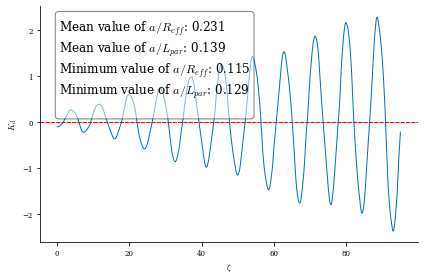

In [21]:
_, R_eff, L_par = plot_Kd(eq,rho=0.8);

In [22]:
print(f"R_eff : {R_eff}")
print(f"L_par : {L_par}")

R_eff : [4.68171825 2.95163856 1.77354405 1.19125058 1.09927332]
L_par : [4.19504405 4.02205254 3.97880467 3.93555679 3.24359076]


In [44]:
a = eq.compute("R0/a")["R0/a"]
print(a)

6.000600589585463


### Check influence of number of wells ###

In [ ]:
def run_well_optimizations(eq, n_wells_array):
    eqfam = EquilibriaFamily(eq)
    for n_wells in n_wells_array:
        eq_test = eq.copy()
        try:
            eq_new = run_step(1, eq_test, n_wells=n_wells)
            eqfam.append(eq_new)
            print(f"Optimization successful for n_wells={n_wells}")
        except Exception as e:
            print(f"Optimization failed for n_wells={n_wells}: {e}")
    return eqfam

In [ ]:
# n_wells_array = [2,3,5,8,10,12]
# eqfam = run_well_optimizations(eq,n_wells_array)

It would seem that the best choice (strongest improvement) is for a number of wells around half of the present number of wells

### Check influence of QS and Aspect ratio weights ###

In [ ]:
def generate_weights(num_weights=4, min_weight=1, max_weight=100):
    """
    Generate logarithmically spaced weights for optimization parameters between min_weight and max_weight.

    Parameters:
    - num_weights: Number of weights to generate for each parameter.
    - min_weight: Minimum weight value.
    - max_weight: Maximum weight value.

    Returns:
    - A list of tuples (qs_weight, aspect_ratio_weight) with all combinations of weights.
    """
    # Generate weights in log space between min_weight and max_weight
    qs_weights = jnp.logspace(
        jnp.log10(min_weight), jnp.log10(max_weight), num=num_weights
    )
    aspect_ratio_weights = jnp.logspace(
        jnp.log10(min_weight), jnp.log10(max_weight), num=num_weights
    )

    # Create all combinations of the weights
    weight_combinations = [(qs, ar) for qs in qs_weights for ar in aspect_ratio_weights]
    return weight_combinations


def run_all_experiments(eq, weight_combinations, maxiter=20):
    """
    Run a series of optimizations for each weight combination and store results.

    Parameters:
    - eq: Initial DESC equilibrium object.
    - weight_combinations: List of (qs_weight, aspect_ratio_weight) tuples.
    - maxiter: Maximum number of iterations for each optimization.
    - method: Optimization method for DESC.
    - target_type: Target type for effective radius optimization.

    Returns:
    - eqfam: EquilibriaFamily containing optimized equilibrium objects.
    - results_df: Pandas DataFrame containing the weight values for each run.
    """
    eqfam = EquilibriaFamily(eq)  # Initialize with initial equilibrium
    results = []  # List to store weight values for each experiment

    for qs_weight, ar_weight in weight_combinations:
        eq_test = eq.copy()
        try:
            # Run optimization for each weight combination
            eq_new = run_step_weights(
                k=1,
                eq=eq_test,
                target=True,
                maxiter=maxiter,
                qs_weight=qs_weight,
                aspect_ratio_weight=ar_weight,
                n_wells=5,
                n_pol=11,
            )
            # Append the new equilibrium to the family
            eqfam.append(eq_new)
            # Log the weight values
            results.append(
                {
                    "qs_weight": qs_weight,
                    "aspect_ratio_weight": ar_weight,
                    "status": "Success",
                }
            )
            print(
                f"Optimization successful for qs_weight={qs_weight}, ar_weight={ar_weight}"
            )
        except Exception as e:
            print(
                f"Optimization failed for qs_weight={qs_weight}, ar_weight={ar_weight}: {e}"
            )
            results.append(
                {
                    "qs_weight": qs_weight,
                    "aspect_ratio_weight": ar_weight,
                    "status": "Failed",
                }
            )

    # Convert results to a DataFrame
    results_df = pd.DataFrame(results)
    return eqfam, results_df

In [ ]:
# # Generate the weight combinations and run experiments
# weight_combinations = generate_weights(num_weights=4)
# eqfam, results_df = run_all_experiments(eq, weight_combinations)

# # Display the results
# print(results_df)

### Check influence of different boundary mode number ###

In [ ]:
def generate_weights(num_weights=4, min_weight=1, max_weight=8):
    """
    Generate logarithmically spaced weights for optimization parameters between min_weight and max_weight.

    Parameters:
    - num_weights: Number of weights to generate for each parameter.
    - min_weight: Minimum weight value.
    - max_weight: Maximum weight value.

    Returns:
    - A list of tuples (qs_weight, aspect_ratio_weight) with all combinations of weights.
    """
    # Generate weights in log space between min_weight and max_weight
    qs_weights = [5,7,9,11]
    aspect_ratio_weights = [5,7,9,11]

    # Create all combinations of the weights
    weight_combinations = [(qs, ar) for qs in qs_weights for ar in aspect_ratio_weights]
    return weight_combinations


def run_all_experiments(eq, weight_combinations, k=1, maxiter=20):
    """
    Run a series of optimizations for each weight combination and store results.

    Parameters:
    - eq: Initial DESC equilibrium object.
    - weight_combinations: List of (qs_weight, aspect_ratio_weight) tuples.
    - maxiter: Maximum number of iterations for each optimization.
    - method: Optimization method for DESC.
    - target_type: Target type for effective radius optimization.

    Returns:
    - eqfam: EquilibriaFamily containing optimized equilibrium objects.
    - results_df: Pandas DataFrame containing the weight values for each run.
    """
    eqfam = EquilibriaFamily(eq)  # Initialize with initial equilibrium
    results = []  # List to store weight values for each experiment

    for qs_weight, ar_weight in weight_combinations:
        eq_test = eq.copy()
        try:
            # Run optimization for each weight combination
            eq_new = run_step_weights_target(
                k=k,
                eq=eq_test,
                target = True,
                maxiter=maxiter,
                qs_weight=qs_weight,
                aspect_ratio_weight=ar_weight,
                n_wells=5,
                n_pol=8,
            )
            # Append the new equilibrium to the family
            eqfam.append(eq_new)
            # Log the weight values
            results.append(
                {
                    "qs_weight": qs_weight,
                    "aspect_ratio_weight": ar_weight,
                    "status": "Success",
                }
            )
            print(
                f"Optimization successful for qs_weight={qs_weight}, ar_weight={ar_weight}"
            )
        except Exception as e:
            print(
                f"Optimization failed for qs_weight={qs_weight}, ar_weight={ar_weight}: {e}"
            )
            results.append(
                {
                    "qs_weight": qs_weight,
                    "aspect_ratio_weight": ar_weight,
                    "status": "Failed",
                }
            )

    # Convert results to a DataFrame
    results_df = pd.DataFrame(results)
    return eqfam, results_df

In [ ]:
# weight_combinations = generate_weights()
# eqfam,results_df = run_all_experiments(eq,weight_combinations,k=3,maxiter=20)

In [51]:
eq_test = eq5.copy()
eq6 = run_step_weights(k=3,eq=eq_test,target=False)

/tmp/ipykernel_1109315/3092260248.py:42: DeprecationWarning: vstack requires ndarray or scalar arguments, got <class 'list'> at position 0. In a future JAX release this will be an error.
  R_modes = jnp.vstack(


Building objective: QS two-term
Precomputing transforms
Timer: Precomputing transforms = 90.2 ms
Building objective: Effective radius
Precomputing transforms
Timer: Precomputing transforms = 127 us
Building objective: aspect ratio
Precomputing transforms
Timer: Precomputing transforms = 62.9 ms
Timer: Objective build = 314 ms
Building objective: force
Precomputing transforms
Timer: Precomputing transforms = 99.7 ms
Timer: Objective build = 127 ms
Timer: Proximal projection build = 6.84 sec
Building objective: lcfs R
Building objective: lcfs Z
Building objective: fixed current
Building objective: fixed Psi
Building objective: fixed ion temperature
Building objective: fixed electron temperature
Building objective: fixed electron density
Building objective: fixed atomic number
Timer: Objective build = 400 ms
Timer: Linear constraint projection build = 3.30 sec
Number of parameters: 48
Number of objectives: 3681
Timer: Initializing the optimization = 10.6 sec

Starting optimization
Using m

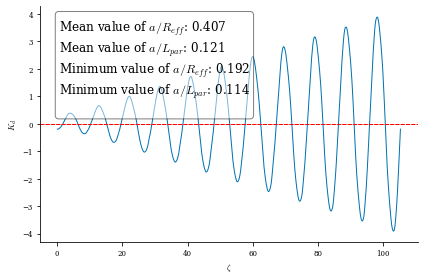

(Grid at 0x7f432ca7a100 (L=0, M=0, N=0, NFP=1, sym=False, is_meshgrid=False, node_pattern=custom, coordinates=rtz),
 Array([2.81897045, 1.50717186, 0.99029553, 0.73249988, 0.58120144],      dtype=float64),
 Array([4.73994757, 4.64419106, 4.54843454, 4.40479977, 3.97389544],      dtype=float64))

In [48]:
plot_Kd(eq)

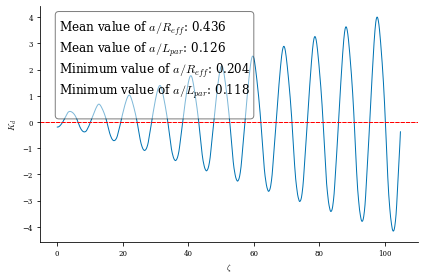

(Grid at 0x7f370f05f1f0 (L=0, M=0, N=0, NFP=1, sym=False, is_meshgrid=False, node_pattern=custom, coordinates=rtz),
 Array([2.67053924, 1.41577526, 0.9293027 , 0.68658919, 0.5424839 ],      dtype=float64),
 Array([4.61780222, 4.5225898 , 4.42737739, 4.23695255, 3.85610288],      dtype=float64))

In [47]:
plot_Kd(eq4)

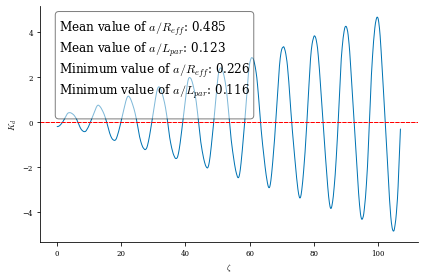

(Grid at 0x7f36eee82730 (L=0, M=0, N=0, NFP=1, sym=False, is_meshgrid=False, node_pattern=custom, coordinates=rtz),
 Array([2.42269474, 1.25851918, 0.83607627, 0.63152935, 0.51062087],      dtype=float64),
 Array([4.72258633, 4.72258633, 4.62521342, 4.43046759, 3.89491656],      dtype=float64))

In [50]:
plot_Kd(eq5)

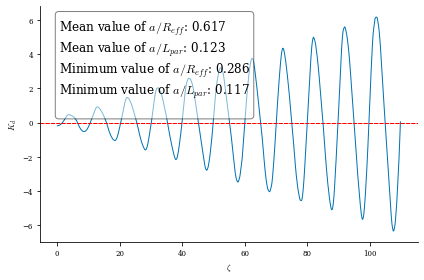

(Grid at 0x7f432790ed00 (L=0, M=0, N=0, NFP=1, sym=False, is_meshgrid=False, node_pattern=custom, coordinates=rtz),
 Array([1.93828894, 0.99088716, 0.67122815, 0.50502402, 0.39165736],      dtype=float64),
 Array([4.7422983 , 4.64246044, 4.59254151, 4.54262258, 4.09335222],      dtype=float64))

In [52]:
plot_Kd(eq6)

(<Figure size 432x432 with 1 Axes>, <Axes: xlabel='$\\rho$'>)

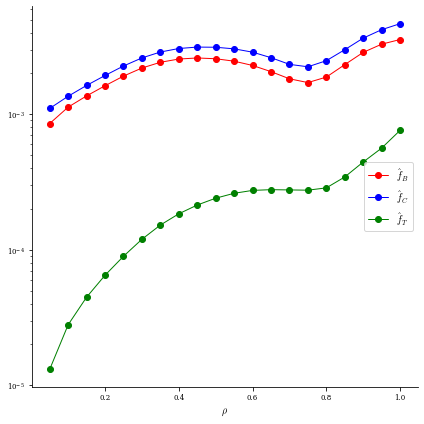

In [30]:
plot_qs_error(eq)

(<Figure size 432x432 with 1 Axes>, <Axes: xlabel='$\\rho$'>)

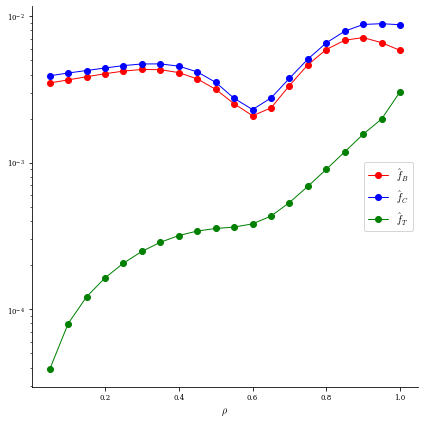

In [53]:
plot_qs_error(eq6)

(<Figure size 432x432 with 1 Axes>,
 <Axes: xlabel='$R ~(\\mathrm{m})$', ylabel='$Z ~(\\mathrm{m})$'>)

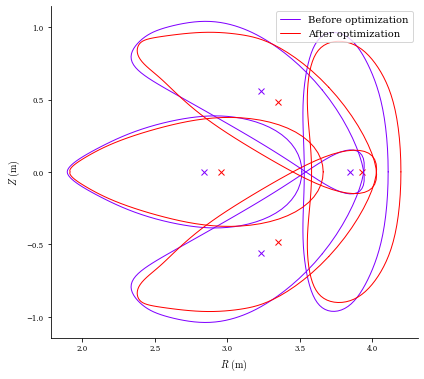

In [58]:
plot_boundaries(
                eqs=[eq, eq6],
                labels=[
                    "Before optimization",
                    "After optimization",
                ],
            )

(<Figure size 432x432 with 2 Axes>,
 <Axes: title={'center': '$|\\mathbf{B}|~(T)$'}, xlabel='$\\zeta_{Boozer}$', ylabel='$\\theta_{Boozer}$'>)

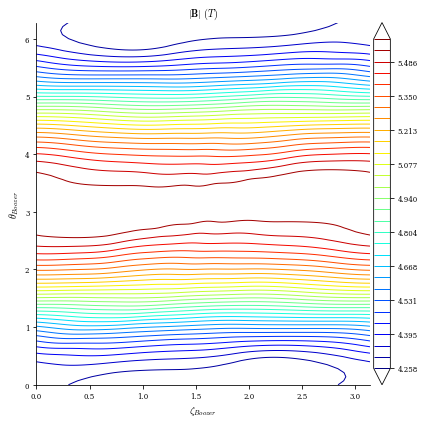

In [59]:
plot_boozer_surface(eq6)

### Running full simulations with all modes ###

In [ ]:
eq_test = eq.copy()

In [ ]:
eqfam2 = run_steps(eq_test,qs_weight=8)

In [ ]:
plot_Kd(eqfam2[0])

In [ ]:
plot_Kd(eqfam2[1])

In [ ]:
plot_Kd(eqfam[2])

In [ ]:
rho=0.5
iota_grid = LinearGrid(rho=rho)
iota = jnp.abs(eqfam2[2].compute("iota", iota_grid)["iota"][0])
grid = get_field_line_grid(eqfam2[2], iota, n_pol=11, rho=rho)
Kd = get_value(eqfam2[2], "Kd", grid)

In [ ]:
plt.figure()
plt.plot(grid.nodes[:,2][475:525],Kd[475:525])
plt.axhline(0,color='r',linestyle='--')

In [ ]:
plot_Kd(eqfam2[3])

In [ ]:
plot_boundaries(
                eqs=[eq, eqfam[2]],
                labels=[
                    "Before optimization",
                    "After optimization",
                ],
            )

In [ ]:
_,ax = plot_qs_error(eqfam[2],fC=False,fT=False)
ax.grid('on')

In [ ]:
plot_boozer_surface(eqfam[2],rho=0.8)

## Data analysis ##

### Comparison plots ###

In [ ]:
def plot_Kd_family(eqfam, results_df, n_pol=11, rho=0.5, n_wells=5):
    """
    Plot Kd for each equilibrium in the family in a 4x4 grid.

    Parameters:
    - eqfam: EquilibriaFamily containing all optimized equilibrium objects.
    - results_df: DataFrame containing weight values for each run.
    - n_pol: Number of poloidal turns for the Kd calculation.
    - rho: Radius in normalized coordinates.
    - n_wells: Number of wells for effective radius optimization.
    """
    # Create a new figure
    fig, axs = plt.subplots(4, 4, figsize=(16, 12))
    fig.suptitle("Kd Plots for Optimized Equilibria", fontsize=16)

    # Iterate over equilibria and corresponding weights
    for i, (eq, ax) in enumerate(zip(eqfam.equilibria[1:], axs.flatten())):
        if i < len(results_df):  # Ensure we have weights for this equilibrium
            qs_weight = results_df.iloc[i]["qs_weight"]
            aspect_ratio_weight = results_df.iloc[i]["aspect_ratio_weight"]
            title = f"qs_weight: {qs_weight:.2f}, ar_weight: {aspect_ratio_weight:.2f}"
            ax.set_title(title)

            # Calculate and plot Kd
            iota_grid = LinearGrid(rho=rho)
            iota = jnp.abs(eq.compute("iota", iota_grid)["iota"][0])
            grid = get_field_line_grid(eq, iota, n_pol=n_pol, rho=rho)
            Kd = get_value(eq, "Kd", grid)
            ax.plot(grid.nodes[:, 2], Kd)
            ax.axhline(0, color="r", linestyle="--")
            ax.set_xlabel(r"$\zeta$")
            ax.set_ylabel(r"$K_d$")

            # Calculate R_eff and L_par for displaying in the text box
            R_eff = eq.compute("R_eff", grid=grid, n_wells=n_wells)["R_eff"]
            L_par = eq.compute("L_par", grid=grid, n_wells=n_wells)["L_par"]
            a = get_value(eq, "a", grid)

            # Format the text to be displayed in the box
            textstr = (
                f"Mean $a/R_{{eff}}$: {a/R_eff.mean():.3f}\n"
                f"Mean $a/L_{{par}}$: {a/L_par.mean():.3f}\n"
                f"Min $a/R_{{eff}}$: {a/R_eff.max():.3f}\n"
                f"Min $a/L_{{par}}$: {a/L_par.max():.3f}\n"
            )

            # Add the text box to the plot
            props = dict(boxstyle="round", facecolor="white", alpha=0.5)
            ax.text(
                0.05,
                0.95,
                textstr,
                transform=ax.transAxes,
                fontsize=10,
                verticalalignment="top",
                bbox=props,
            )
            ax.grid()
        else:
            ax.axis("off")  # Turn off axes if there are more subplots than equilibria

    plt.tight_layout(rect=[0, 0, 1, 0.96])  # Adjust layout
    plt.show()


# Example usage

In [ ]:
def plot_boozer_family(
    eqfam, results_df, rho=0.5, fill=False, ncontours=30, fieldlines=0
):
    """
    Plot quasisymmetry for each equilibrium in the family in a 4x4 grid.

    Parameters:
    - eqfam: EquilibriaFamily containing all optimized equilibrium objects.
    - results_df: DataFrame containing weight values for each run.
    - rho: Radius in normalized coordinates.
    - fill: Whether the contours are filled, i.e. whether to use `contourf` or `contour`.
    - ncontours: Number of contours to plot.
    - fieldlines: Number of (linearly spaced) magnetic fieldlines to plot. Default is 0 (none).
    """
    # Create a new figure
    fig, axs = plt.subplots(4, 4, figsize=(16, 12))
    fig.suptitle("Quasisymmetry Plots for Optimized Equilibria", fontsize=16)

    # Iterate over equilibria and corresponding weights
    for i, (eq, ax) in enumerate(zip(eqfam.equilibria[1:], axs.flatten())):
        if i < len(results_df):  # Ensure we have weights for this equilibrium
            qs_weight = results_df.iloc[i]["qs_weight"]
            aspect_ratio_weight = results_df.iloc[i]["aspect_ratio_weight"]
            title = f"qs_weight: {qs_weight:.2f}, ar_weight: {aspect_ratio_weight:.2f}"
            ax.set_title(title)

            # Plot Boozer surface for the current equilibrium
            plot_boozer_surface(
                eq,
                rho=rho,
                fill=fill,
                ncontours=ncontours,
                fieldlines=fieldlines,
                ax=ax,
            )

            # Customize the plot axes
            ax.axhline(0, color="r", linestyle="--")

            # Optionally, you can add additional calculated values to the text box
            textstr = (
                f"qs_weight: {qs_weight:.2f}\n"
                f"ar_weight: {aspect_ratio_weight:.2f}\n"
            )

            # Add the text box to the plot
            props = dict(boxstyle="round", facecolor="white", alpha=0.5)
            ax.text(
                0.05,
                0.95,
                textstr,
                transform=ax.transAxes,
                fontsize=10,
                verticalalignment="top",
                bbox=props,
            )
        else:
            ax.axis("off")  # Turn off axes if there are more subplots than equilibria

    plt.tight_layout(rect=[0, 0, 1, 0.96])  # Adjust layout
    plt.show()


# Example usage

In [ ]:
def plot_quasisymmetry_error_family(eqfam, results_df):
    """
    Plot quasisymmetry error for each equilibrium in the family in a 4x4 grid.

    Parameters:
    - eqfam: EquilibriaFamily containing all optimized equilibrium objects.
    - results_df: DataFrame containing weight values for each run.
    """
    # Create a new figure
    fig, axs = plt.subplots(4, 4, figsize=(16, 12))
    fig.suptitle("Quasisymmetry Error for Optimized Equilibria", fontsize=16)

    eq_initial = eqfam[0]

    # Iterate over equilibria and corresponding weights
    for i, (eq, ax) in enumerate(zip(eqfam.equilibria[1:], axs.flatten())):
        if i < len(results_df):  # Ensure we have weights for this equilibrium
            qs_weight = results_df.iloc[i]["qs_weight"]
            aspect_ratio_weight = results_df.iloc[i]["aspect_ratio_weight"]
            title = f"qs_weight: {qs_weight:.2f}, ar_weight: {aspect_ratio_weight:.2f}"
            ax.set_title(title)

            # Plot QS error for eq_initial and the current equilibrium
            fig_qs_error, ax = plot_qs_error(
                eq_initial,
                helicity=(1, 0),
                fT=False,
                fC=False,
                legend=False,
                rho=10,
                ax=ax,
            )
            plot_qs_error(
                eq, helicity=(1, 0), fT=False, fC=False, ax=ax, marker=["x"], rho=10
            )

            # Add the weight information in a text box
            textstr = (
                f"qs_weight: {qs_weight:.2f}\n"
                f"ar_weight: {aspect_ratio_weight:.2f}\n"
            )

            # Create a text box with the weight information
            props = dict(boxstyle="round", facecolor="white", alpha=0.5)
            ax.text(
                0.05,
                0.95,
                textstr,
                transform=ax.transAxes,
                fontsize=10,
                verticalalignment="top",
                bbox=props,
            )
            ax.grid()
        else:
            ax.axis("off")  # Turn off axes if there are more subplots than equilibria

    plt.tight_layout(rect=[0, 0, 1, 0.96])  # Adjust layout
    plt.show()


# Example usage

In [ ]:
def plot_boundaries_family(
    eqfam, results_df, rho=0.5, fill=False, ncontours=30, fieldlines=0
):
    """
    Plot quasisymmetry for each equilibrium in the family in a 4x4 grid.

    Parameters:
    - eqfam: EquilibriaFamily containing all optimized equilibrium objects.
    - results_df: DataFrame containing weight values for each run.
    - rho: Radius in normalized coordinates.
    - fill: Whether the contours are filled, i.e. whether to use `contourf` or `contour`.
    - ncontours: Number of contours to plot.
    - fieldlines: Number of (linearly spaced) magnetic fieldlines to plot. Default is 0 (none).
    """
    # Create a new figure
    eq_initial = eqfam[0]
    fig, axs = plt.subplots(4, 4, figsize=(16, 12))
    fig.suptitle("Quasisymmetry Plots for Optimized Equilibria", fontsize=16)

    # Iterate over equilibria and corresponding weights
    for i, (eq, ax) in enumerate(zip(eqfam.equilibria[1:], axs.flatten())):
        if i < len(results_df):  # Ensure we have weights for this equilibrium
            qs_weight = results_df.iloc[i]["qs_weight"]
            aspect_ratio_weight = results_df.iloc[i]["aspect_ratio_weight"]
            title = f"qs_weight: {qs_weight:.2f}, ar_weight: {aspect_ratio_weight:.2f}"
            ax.set_title(title)

            # Plot boundaries for the current equilibrium
            plot_boundaries(
                eqs=[eq_initial, eq],
                labels=[
                    "Before optimization",
                    "After optimization",
                ],
                ax=ax,
            )

            # Customize the plot axes
            ax.axhline(0, color="r", linestyle="--")

            # Add the text box to the plot
            textstr = (
                f"qs_weight: {qs_weight:.2f}\n"
                f"ar_weight: {aspect_ratio_weight:.2f}\n"
            )

            # Create a text box with the weight information
            props = dict(boxstyle="round", facecolor="white", alpha=0.5)
            ax.text(
                0.05,
                0.95,
                textstr,
                transform=ax.transAxes,
                fontsize=10,
                verticalalignment="top",
                bbox=props,
            )
        else:
            ax.axis("off")  # Turn off axes if there are more subplots than equilibria

    plt.tight_layout(rect=[0, 0, 1, 0.96])  # Adjust layout
    plt.show()


# Example usage

### Testing ###

In [ ]:
# Example usage
plot_Kd_family(eqfam, results_df)

In [ ]:
plot_boozer_family(eqfam, results_df)

In [ ]:
plot_quasisymmetry_error_family(eqfam, results_df)

In [ ]:
plot_boundaries_family(eqfam, results_df)